In [87]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [88]:
import os
dir = '/Users/signapoop/Desktop/autotune'
os.chdir(dir)
from autotune.core.HyperbandOptimiser import HyperbandOptimiser
from autotune.core.RandomOptimiser import RandomOptimiser
from autotune.core.TpeOptimiser import TpeOptimiser

In [89]:
hyperband = []
random = []
tpe = []
n = 5

for i in range(1,n+1):

    problem_text = "cifar_9hps_" + str(i)
    path = '/Users/signapoop/Desktop/results/' + problem_text
    os.chdir(path)
    file = open("results_new.pkl",'rb')
    object_file = pickle.load(file)
    file.close()
    
    file = open("tpe_only_results.pkl",'rb')
    object_file_2 = pickle.load(file)
    file.close()

    # Unpack file
    hyperband.append(object_file[0])
    random.append(object_file[1])
    tpe.append(object_file_2[0])

In [90]:
def predecessor_t(seq, t):
    assert seq[0] == 0, "First checkpoint must be 0"
    for i in range(len(seq)):
        if seq[i] > t:
            return i -1
    return i 

def value_at_time(opt, t):
    time_index = predecessor_t(opt.checkpoints, t)
    return opt.Y_best[time_index]

def augment_sequences(opt):
    opt.checkpoints.insert(0,0)
    opt.Y_best.insert(0,1)

In [91]:
# augments sequences, prepending checkpoint t=0, Y_best=1
for opt in hyperband: 
    augment_sequences(opt)

for opt in random: 
    augment_sequences(opt)
    
for opt in tpe: 
    augment_sequences(opt)

In [92]:
for h in hyperband:
    print(len(h.checkpoints))
    print(h.checkpoints[-1])
    print(h.Y_best[-1])

13
3975.34565401
0.1751
13
3838.71892691
0.1672
13
4195.15152001
0.1511
13
4082.96069717
0.205
13
5094.82933521
0.1624


In [93]:
for r in random:
    print(len(r.checkpoints))
    print(r.checkpoints[-1])
    print(r.Y_best[-1])

25
7126.3059752
0.1926
31
7202.31389594
0.2099
28
7068.14847112
0.1818
27
7290.26990414
0.1666
28
7318.24767995
0.2


In [94]:
for r in tpe:
    print(len(r.checkpoints))
    print(r.checkpoints[-1])
    print(r.Y_best[-1])

26
7120.7435658
0.1649
26
7743.94
0.1676
26
7733.63
0.1722
26
5975.03
0.2198
26
6925.1020999
0.1764


In [95]:
seq = random[0].checkpoints
print(seq)
print(predecessor_t(seq, 4900))
print(value_at_time(random[0], 4900))

[0, 195.61415219306946, 464.95212411880493, 683.1708462238312, 1033.7334711551666, 1427.0087699890137, 1966.8957250118256, 2401.702977180481, 2712.751177072525, 2968.233455181122, 3236.775369167328, 3430.925395011902, 3607.5446190834045, 3912.3505091667175, 4247.16658616066, 4563.242060184479, 4919.472505092621, 5281.639325141907, 5482.223252058029, 5857.039348125458, 6169.917241096497, 6381.839071035385, 6710.281660079956, 6916.512364149094, 7126.305975198746]
15
0.1934


In [96]:
def average_opt_results(optimisers):
    t_end = max([opt.checkpoints[-1] for opt in optimisers])
    print(t_end)
    t_seq = np.linspace(0, t_end, num=250)
    
    y_seq = np.zeros((len(optimisers),len(t_seq)))
    for i in range(len(optimisers)):
        for j in range(len(t_seq)):
            y_seq[i][j] = value_at_time(optimisers[i], t_seq[j])
    return t_seq, y_seq

In [97]:
random_t_seq, random_y_seq = average_opt_results(random)
print(random_y_seq.shape)
hyperband_t_seq, hyperband_y_seq = average_opt_results(hyperband)
print(hyperband_y_seq.shape)
tpe_t_seq, tpe_y_seq = average_opt_results(tpe)
print(tpe_y_seq.shape)

7318.24767995
(5, 250)
5094.82933521
(5, 250)
7743.94
(5, 250)


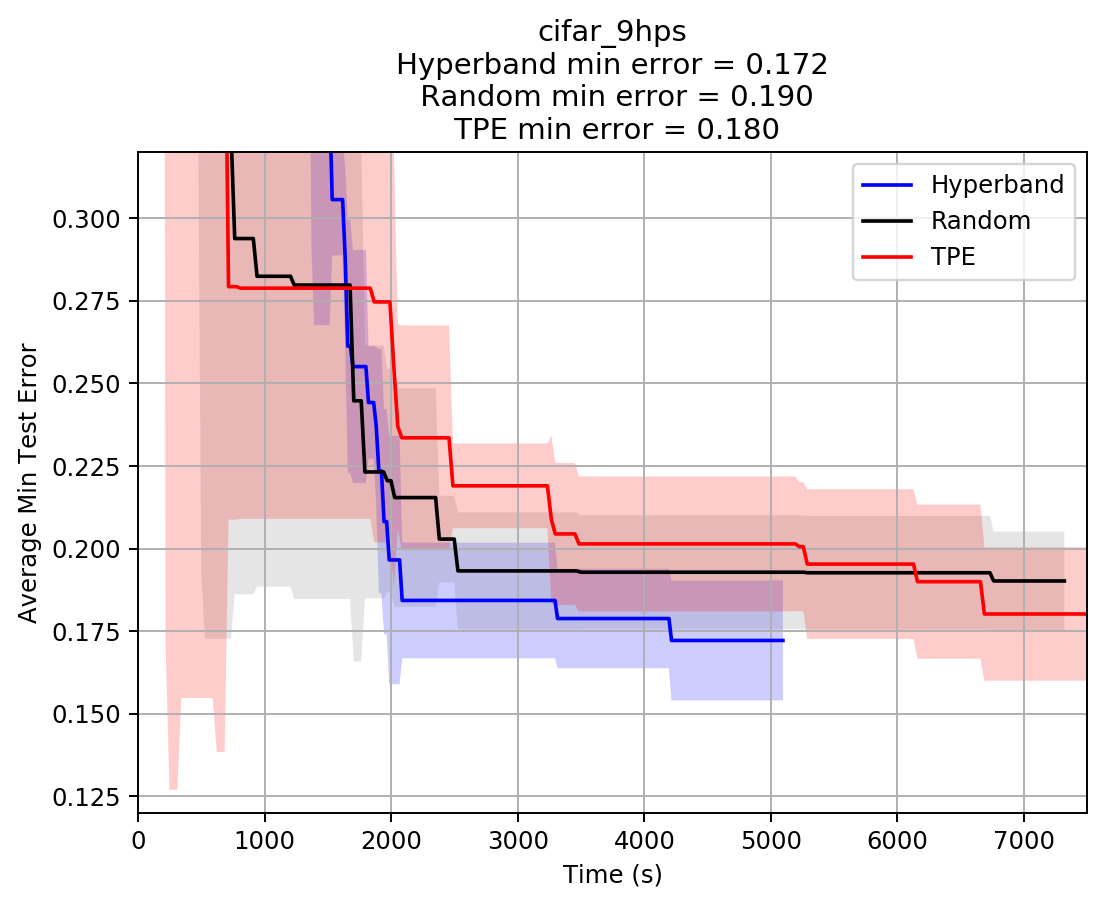

In [98]:
r_a = np.average(random_y_seq, 0)
h_a = np.average(hyperband_y_seq, 0)
t_a = np.average(tpe_y_seq, 0)

r_s = np.std(random_y_seq, 0)
h_s = np.std(hyperband_y_seq, 0)
t_s = np.std(tpe_y_seq, 0)

fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=175)
ax.plot(hyperband_t_seq, h_a, '-b', label="Hyperband")
ax.fill_between(hyperband_t_seq, h_a-h_s, h_a+h_s, facecolor='blue', alpha=0.2)

ax.plot(random_t_seq, r_a, '-k', label="Random")
ax.fill_between(random_t_seq, r_a-r_s, r_a+r_s, facecolor='grey', alpha=0.2)

ax.plot(tpe_t_seq, t_a, '-r', label="TPE")
ax.fill_between(tpe_t_seq, t_a-t_s, t_a+t_s, facecolor='red', alpha=0.2)

ax.set_xlim(0.0,7500)
#ax.set_ylim(0.1,0.8)
ax.set_ylim(0.12,0.32)

ax.grid()
plt.ylabel('Average Min Test Error')
plt.xlabel('Time (s)')
plt.legend()

problem_text = "cifar_9hps"

res = "Hyperband min error = {:.3f}\n Random min error = {:.3f}\n TPE min error = {:.3f}".format(min(h_a), min(r_a), min(t_a))
title = problem_text + "\n" + res
plt.title(title)
    
plt.show()

In [17]:
random_std = np.std(random_y_seq, 0)